In [1]:
import os
import sys

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils as utils
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

import matplotlib as  mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import google.colab
google.colab.drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/projects/temporature-hackathon/')

Mounted at /content/drive


In [26]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('sample_submission.csv')

In [27]:
df.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


In [28]:
df = df.rename(columns={
    '일시': 'date',
    '최고기온': 'max_temp',
    '최저기온': 'min_temp',
    '평균기온': 'avg_temp',
    '일교차': 'temp_diff',
    '강수량': 'rainfall',
    '평균습도': 'avg_humidity',
    '평균풍속': 'avg_wind_speed',
    '일조합': 'sunshine',
    '일사합': 'sunshine_hours',
    '일조율': 'sunshine_ratio'
})
df['date'] = df['date'].astype('datetime64[ns]')
df = df.set_index('date')
df.head()

,max_temp,min_temp,temp_diff,rainfall,avg_humidity,avg_wind_speed,sunshine,sunshine_hours,sunshine_ratio,avg_temp
date,,,,,,,,,,
1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


In [29]:
test_df.head()

,일시,평균기온
0,2023-01-01,11.131848
1,2023-01-02,11.649268
2,2023-01-03,11.744956
3,2023-01-04,11.765481
4,2023-01-05,11.770414


In [30]:
len(test_df)

358

In [31]:
df.isna().sum()

max_temp              3
min_temp              3
temp_diff             4
rainfall          13861
avg_humidity          0
avg_wind_speed        4
sunshine            118
sunshine_hours     4862
sunshine_ratio      366
avg_temp              0
dtype: int64

In [32]:
df.isna().mean() * 10

max_temp          0.001304
min_temp          0.001304
temp_diff         0.001738
rainfall          6.023641
avg_humidity      0.000000
avg_wind_speed    0.001738
sunshine          0.051280
sunshine_hours    2.112903
sunshine_ratio    0.159054
avg_temp          0.000000
dtype: float64

In [33]:
df[(pd.Timestamp('1990-03-01') <= df.index)].isna().mean() * 10

max_temp          0.000834
min_temp          0.000834
temp_diff         0.001668
rainfall          6.134734
avg_humidity      0.000000
avg_wind_speed    0.002501
sunshine          0.011673
sunshine_hours    0.023345
sunshine_ratio    0.000000
avg_temp          0.000000
dtype: float64

In [36]:
df.columns

Index(['max_temp', 'min_temp', 'temp_diff', 'rainfall', 'avg_humidity',
       'avg_wind_speed', 'sunshine', 'sunshine_hours', 'sunshine_ratio',
       'avg_temp'],
      dtype='object')

In [37]:
df[['max_temp', 'min_temp', 'temp_diff', 'rainfall', 'avg_humidity', 'avg_wind_speed', 'sunshine']] = df[['max_temp', 'min_temp', 'temp_diff', 'rainfall', 'avg_humidity', 'avg_wind_speed', 'sunshine']].interpolate()
df[['rainfall', 'sunshine_hours', 'sunshine_ratio']] = df[['rainfall', 'sunshine_hours', 'sunshine_ratio']].fillna(df[['rainfall', 'sunshine_hours', 'sunshine_ratio']].median())
df.isna().sum()

max_temp          0
min_temp          0
temp_diff         0
rainfall          0
avg_humidity      0
avg_wind_speed    0
sunshine          0
sunshine_hours    0
sunshine_ratio    0
avg_temp          0
dtype: int64

<Axes: xlabel='date'>

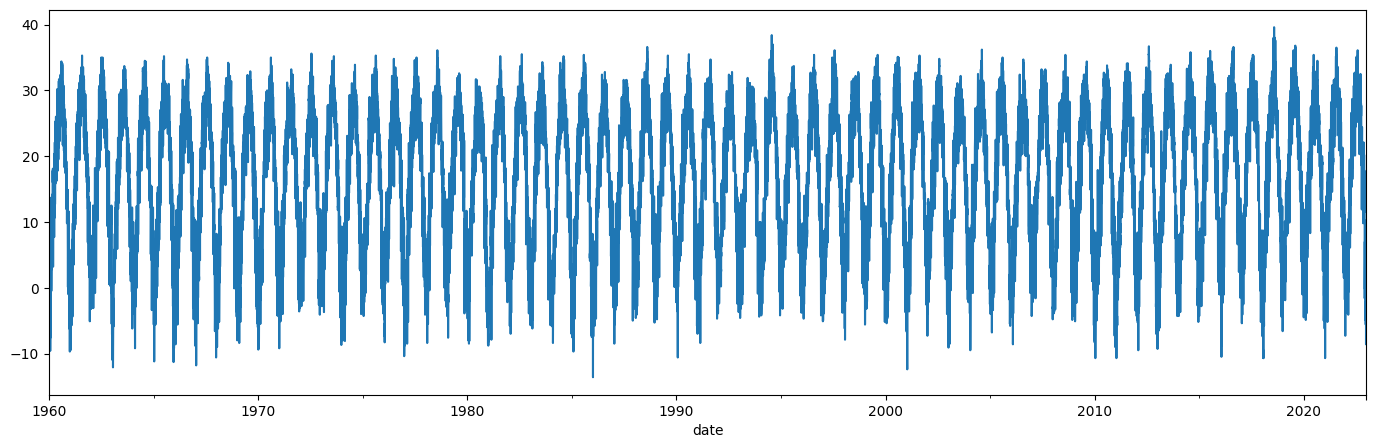

In [43]:
df['max_temp'].plot(figsize=(17, 5))

<Axes: xlabel='date'>

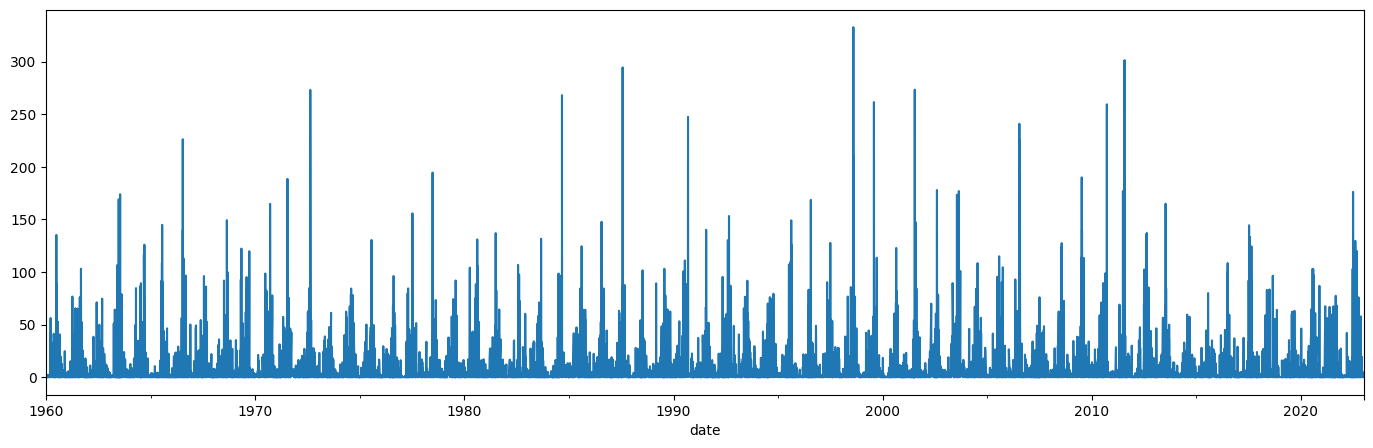

In [44]:
df['rainfall'].plot(figsize=(17, 5))

<Axes: xlabel='date'>

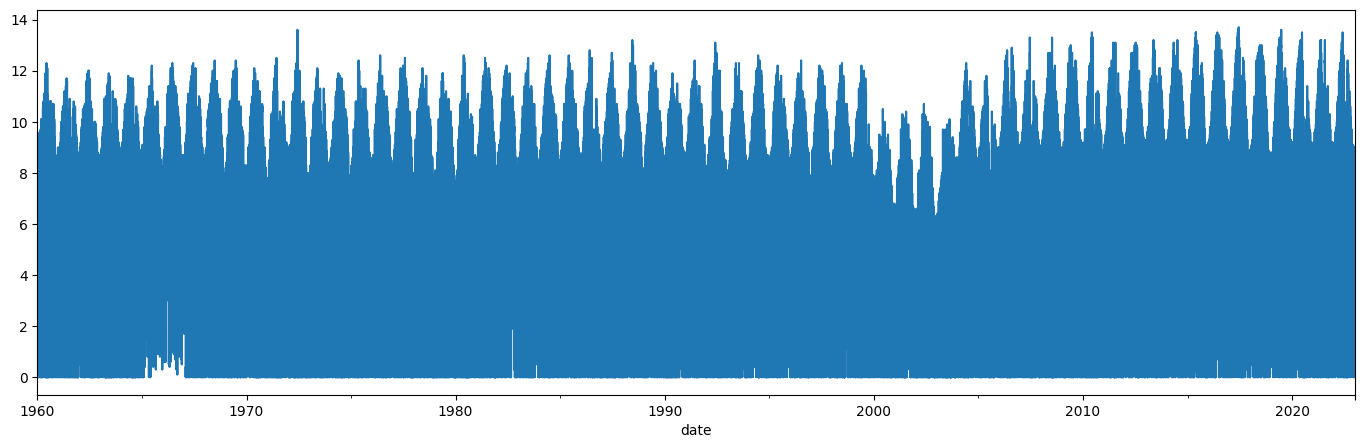

In [45]:
df['sunshine'].plot(figsize=(17, 5))

In [13]:
df.tail()

,max_temp,min_temp,temp_diff,rainfall,avg_humidity,avg_wind_speed,sunshine,sunshine_hours,sunshine_ratio,avg_temp
date,,,,,,,,,,
2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8
2022-12-31,2.1,-5.1,7.2,0.0,65.5,1.4,1.1,4.16,11.5,-1.2


<Axes: >

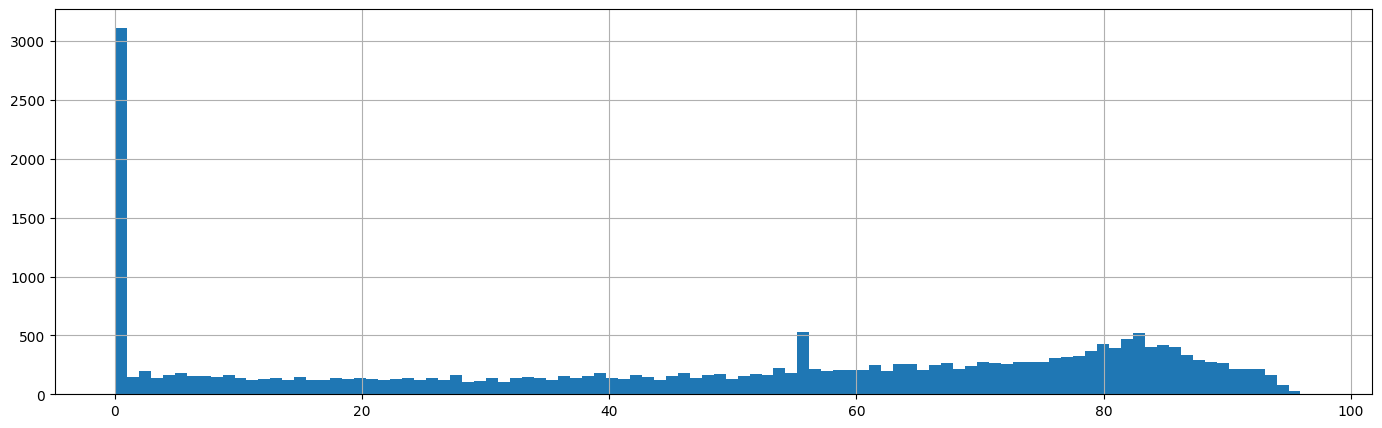

In [46]:
df['sunshine_ratio'].hist(bins=100, figsize=(17, 5))

In [47]:
df.corr()['avg_temp']

max_temp          0.989548
min_temp          0.989342
temp_diff         0.046920
rainfall          0.248747
avg_humidity      0.376363
avg_wind_speed   -0.209078
sunshine         -0.031165
sunshine_hours    0.315411
sunshine_ratio   -0.216544
avg_temp          1.000000
Name: avg_temp, dtype: float64

In [48]:
train_df = df.backfill()
train_df['max_temp'] = StandardScaler().fit_transform(train_df['max_temp'].values.reshape(-1, 1))
train_df['min_temp'] = StandardScaler().fit_transform(train_df['min_temp'].values.reshape(-1, 1))
train_df['temp_diff'] = StandardScaler().fit_transform(train_df['temp_diff'].values.reshape(-1, 1))
train_df['avg_humidity'] = StandardScaler().fit_transform(train_df['avg_humidity'].values.reshape(-1, 1))
train_df['avg_wind_speed'] = StandardScaler().fit_transform(train_df['avg_wind_speed'].values.reshape(-1, 1))
train_df['sunshine_hours'] = StandardScaler().fit_transform(train_df['sunshine_hours'].values.reshape(-1, 1))

train_df['rainfall'] = MinMaxScaler().fit_transform(train_df['sunshine_hours'].values.reshape(-1, 1)) * 2 - 1
train_df['sunshine'] = MinMaxScaler().fit_transform(train_df['sunshine'].values.reshape(-1, 1)) * 2 - 1
train_df['sunshine_ratio'] = MinMaxScaler().fit_transform(train_df['sunshine_hours'].values.reshape(-1, 1)) * 2 - 1

In [49]:
train_df.values.shape

(23011, 10)

In [50]:
input_lt = []
output_lt = []

for i in range(0, len(train_df), 358):
    input_lt.append(torch.tensor(train_df.iloc[i : i + 358 * 3].drop(columns=['avg_temp']).values))
    output_lt.append(torch.tensor(train_df.iloc[i + 358 * 3 : i + 358 * 4]['avg_temp'].values))

input = torch.stack(input_lt[:-4])
output = torch.stack(output_lt[:-4])

In [51]:
input.shape

torch.Size([61, 1074, 9])

In [52]:
output.shape

torch.Size([61, 358])

In [53]:
torch.save(input, 'input.pt')
torch.save(output, 'output.pt')

In [54]:
test_df.to_csv('sample_submission.csv', index=False)

In [55]:
len(test_df)

358